<a href="https://colab.research.google.com/github/LubomyrIvanitskiy/CheXpert/blob/main/XRayPOC_Image_Investigation_2_29_10_21_Pixel_Covariation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rsync --info=progress2 /content/drive/MyDrive/XRayPOC/chest.zip chest.zip

 11,557,753,157 100%   80.44MB/s    0:02:17 (xfr#1, to-chk=0/1)


In [ ]:
!sudo apt-get install p7zip-full
!7z x chest.zip -odataset

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 11557753157 bytes (11 GiB)

Extracting archive: chest.zip
  0% 4096 Open               41% 196608 Open                 83% 397312 Open                --
Path = chest.zip
Type = zip
Physical Size = 11557753157
64-bit = +

  0%    
Would you like to replace the existing file:
  Path:     dataset/CheXpert-v1.0-small/valid/patient64723/study1/view1_frontal.jpg
  Size:     46279 bytes (46 KiB)
  Modified: 2019

In [ ]:
import pandas as pd
train_df = pd.read_csv("/content/dataset/CheXpert-v1.0-small/train.csv")
valid_df = pd.read_csv("/content/dataset/CheXpert-v1.0-small/valid.csv")
print(train_df.columns)
illness = "Cardiomegaly"

def pure_table(df):
  """
  Returns rows where the illness is only present (no other illnesses)
  """
  except_column = illness
  condition = df[illness].notna()
  for column in df.columns[6:]:
    if column == except_column or column=="Weight":
      continue
    condition &= (df[column] == 0.0)
  condition &= ((df[except_column] == "1.0") | (df["No Finding"] == 1.0))
  return df[condition]

def prepare_table(df, column, count=None):
  df = df.fillna(0)
  df = df[df["Frontal/Lateral"] == "Frontal"]
  df = df[df[column] >= 0]
  df["Weight"]=0
  w0 = len(df[df[column] == 1])/len(df[df[column] == 0])
  w1 = 1
  df.loc[df[column] == 0, 'Weight'] = w0
  df.loc[df[column] == 1, 'Weight'] = w1
  df[column] = df[column].astype("string")
  if count is None:
    return df
  else:
    return df.head(count)
    

train_df[illness] = train_df[illness].fillna(0)

count = None
train_df = prepare_table(train_df, illness, count=count)
valid_df = prepare_table(valid_df, illness, count=count)

train_df = pure_table(train_df)
valid_df = valid_df

w0 = len(train_df[train_df[illness] == "1.0"])/len(train_df[train_df[illness] == "0.0"])
w1 = 1
print(f"With {illness} = {len(train_df[train_df[illness] == '1.0'])}")
print(f"No Finding = {len(train_df[train_df['No Finding'] == 1.0])}")

ill_count = len(train_df[train_df[illness] == '1.0'])

undersampled = pd.concat([train_df[train_df[illness]=='1.0'], train_df[train_df['No Finding']==1.0].head(ill_count)]).sample(frac=1).reset_index(drop=True)
print("ill_count", ill_count)
print("undersampled", len(undersampled))
print(f"undersampled With {illness} = {len(undersampled[undersampled[illness] == '1.0'])}")
print(f"undersampled No Finding = {len(undersampled[undersampled['No Finding'] == 1.0])}")
train_df = undersampled



Index(['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices'],
      dtype='object')
With Cardiomegaly = 1034
No Finding = 9474
ill_count 1034
undersampled 2068
undersampled With Cardiomegaly = 1034
undersampled No Finding = 1034


In [ ]:
from IPython.core.display import HTML
from PIL import Image
from io import BytesIO
import base64


def get_thumbnail(path):
    path = "/content/dataset/"+path
    i = Image.open(path)
    i.thumbnail((250, 250), Image.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'


,Path,Cardiomegaly,No Finding
0,,1.0,0.0
1,,1.0,0.0
2,,1.0,0.0
3,,1.0,0.0
4,,0.0,1.0
5,,0.0,1.0
6,,0.0,1.0
7,,1.0,0.0
8,,1.0,0.0
9,,0.0,1.0

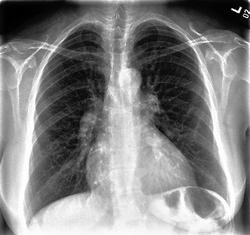
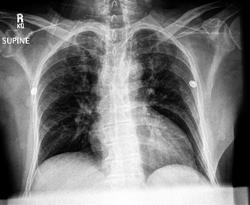
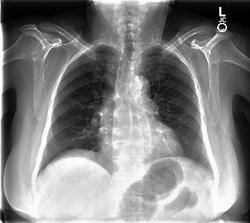
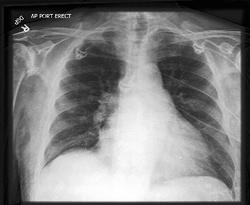
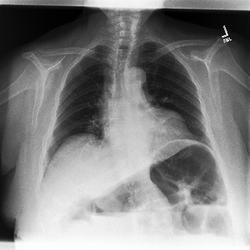
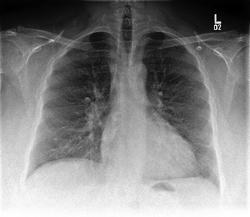
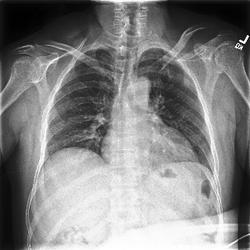
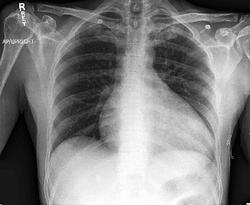
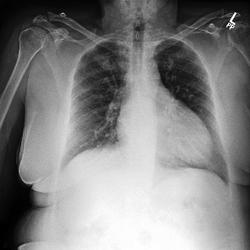
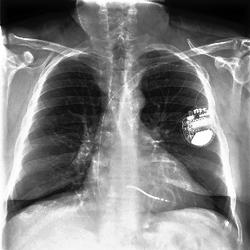
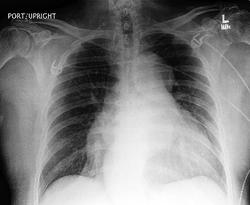
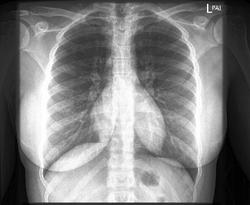
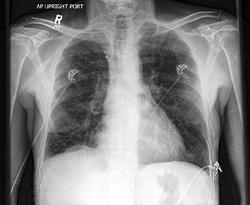
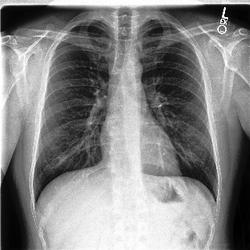
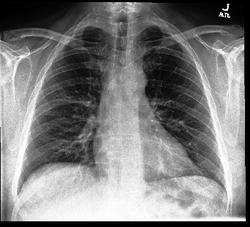
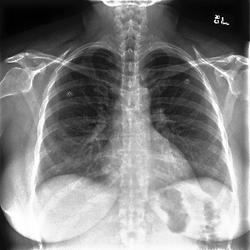
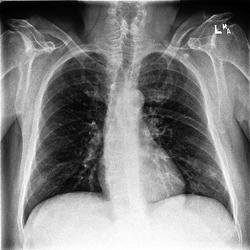
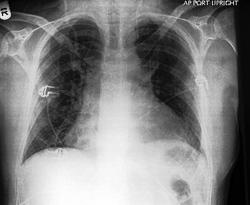
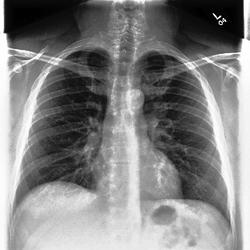
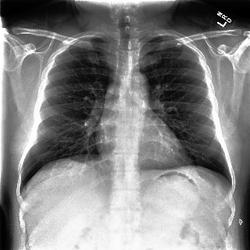
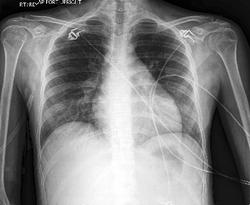
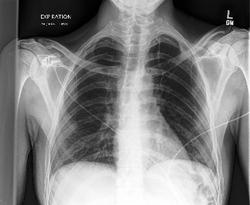
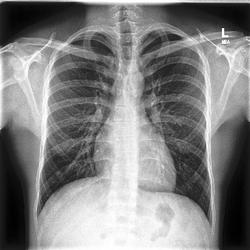
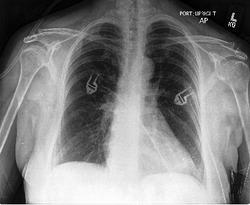
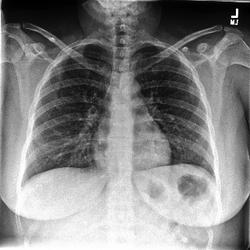
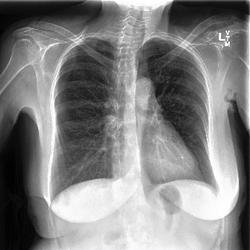
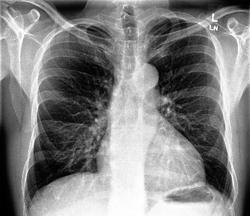
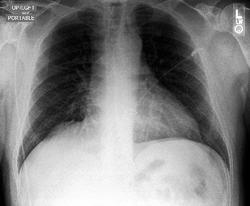
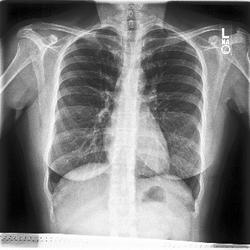
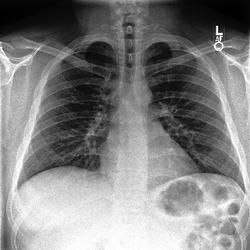

In [ ]:
HTML(train_df.head(30)[["Path", illness, "No Finding"]].to_html(formatters={'Path': image_formatter}, escape=False))

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

test_data_gen = ImageDataGenerator(rescale = 1./255)
im_size = (128, 128)
train_data = test_data_gen.flow_from_dataframe(train_df, 
                                  directory="dataset",
                                  x_col="Path",
                                  y_col=illness, 
                                  weight_col="Weight", 
                                  target_size=im_size, 
                                  color_mode="grayscale",
                                  class_mode="binary", 
                                  batch_size=32, 
                                  seed=42)
valid_data = test_data_gen.flow_from_dataframe(valid_df, 
                                  directory="dataset",
                                  x_col="Path",
                                  y_col=illness, 
                                  weight_col="Weight", 
                                  target_size=im_size, 
                                  color_mode="grayscale",
                                  class_mode="binary", 
                                  batch_size=32,
                                  shuffle=False, 
                                  seed=43)
type(train_data)

Found 2068 validated image filenames belonging to 2 classes.
Found 202 validated image filenames belonging to 2 classes.


keras.preprocessing.image.DataFrameIterator

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch, _ in train_data:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:illness}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(image[:,:,0], cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

In [ ]:
batch_size = 2000
import numpy as np

train_data.batch_size=batch_size

positive_images = train_data[0][0][np.asarray(train_data[0][1])==1]
negative_images = train_data[0][0][np.asarray(train_data[0][1])==0]

avarage_negative_image = negative_images.mean(axis=0)[:,:,0]
avarage_positive_image = positive_images.mean(axis=0)[:,:,0]
avarage_std_negative_image = negative_images.std(axis=0)[:,:,0]
avarage_std_positive_image = positive_images.std(axis=0)[:,:,0]

train_data.batch_size=32

In [ ]:
from sklearn.cluster import MiniBatchKMeans
# Initialize the K-Means model
def split_kmeans(images, class_count = 4):
  kmeans = MiniBatchKMeans(n_clusters = class_count)
  # Fitting the model to training set
  kmean_images = images[:,:,:,0].reshape(len(images), -1)
  kmeans.fit(kmean_images)
  groups = []
  for clas in range(class_count):
    groups.append(images[kmeans.labels_==clas])
  return groups

def show_groups(image_groups, view_count, title=""):
  class_count = len(image_groups)
  fig, ax = plt.subplots(view_count, class_count, figsize=(5*class_count,view_count*3))
  for i in range(view_count):
    for class_index in range(class_count):
      if i==0:
        ax[i][class_index].set_title("Index"+str(class_index))
      ax[i][class_index].imshow(image_groups[class_index][i][:,:,0], cmap="gray")
  plt.title(title)
  plt.show()

In [ ]:
def get_groups_snapshots(image_groups):
    class_count = len(image_groups)
    snapshots = []
    for class_index in range(class_count):
      snapshots.append(image_groups[class_index][:,:,:,0].mean(axis=0))
    return np.asarray(snapshots)

In [ ]:
view_count = 5
class_count = 2

positive_groups = split_kmeans(positive_images, class_count)
negative_groups = split_kmeans(negative_images, class_count)

show_groups(positive_groups, view_count, title="Positive Groups")
show_groups(negative_groups, view_count, title="Negative Groups")

#exp

Find covariation. Each pixel history covariate with other. Let's show it

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
i,j=10,10
neg = negative_images
pos = positive_images
neg=(neg-neg.mean())/neg.std()
pos=(pos-pos.mean())/pos.std()

scans = []
for i in range(0,im_size[0], 5):
  for j in range(0,im_size[1], 5):
    if j%100==0:
      print(i,j)
    neg_multiplier = neg[:,i,j,0].reshape((-1,1,1,1))
    pos_multiplier = pos[:,i,j,0].reshape((-1,1,1,1))
    neg_result = neg*neg_multiplier
    pos_result = pos*pos_multiplier
    neg_result = neg_result[...,0].mean(axis=0)
    pos_result = pos_result[...,0].mean(axis=0)
    result=np.stack([pos_result,neg_result,np.zeros_like(pos_result)], axis=-1)
    result[i,j,2] = 2
    scans.append(result)

0 0
0 100
5 0
5 100
10 0
10 100
15 0
15 100
20 0
20 100
25 0
25 100
30 0
30 100
35 0
35 100
40 0
40 100
45 0
45 100
50 0
50 100
55 0
55 100
60 0
60 100
65 0
65 100
70 0
70 100
75 0
75 100
80 0
80 100
85 0
85 100
90 0
90 100
95 0
95 100
100 0
100 100
105 0
105 100
110 0
110 100
115 0
115 100
120 0
120 100
125 0
125 100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


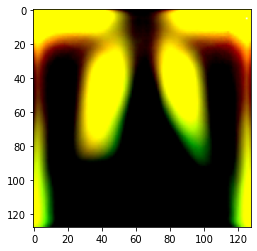

In [12]:
plt.imshow(scans[51])

In [ ]:
stacked = np.stack(scans)
means = np.reshape(np.mean(stacked.reshape(-1, im_size[0]*im_size[1]*3), axis=1), (-1,1,1,1))
stds = np.reshape(np.std(stacked.reshape(-1, im_size[0]*im_size[1]*3), axis=1), (-1,1,1,1))
stacked = (stacked-means)/stds

In [ ]:
scans

NameError: ignored

In [10]:
from moviepy.editor import ImageSequenceClip
clip = ImageSequenceClip(list(stacked), fps=50)
clip.write_gif('test3.gif', fps=50)


[MoviePy] Building file test3.gif with imageio


100%|██████████| 676/676 [00:02<00:00, 286.57it/s]


In [ ]:
# test_image = np.mean(positive_images[...,0], axis=0)
i,j=30,60
import numpy as np
test_image = np.var(positive_images*positive_images[:,0,0,:], axis=0)
# test_image.shape
plt.imshow(test_image[...,0], cmap='gray')

In [ ]:
differ = np.diff(positive_images, n=100, axis=0)

In [ ]:
plt.imshow(differ[0,...,0])

Exp end

In [ ]:
def binary(im):
  return 1-(im>0.4)*1

def process(im):
  return im

In [ ]:
positive_snapshots = get_groups_snapshots(positive_groups)
negative_snapshots = get_groups_snapshots(negative_groups)

single_image = positive_images[4][:,:,0]

fig, ax = plt.subplots(3,class_count, figsize=(5*class_count,10))
for group_index in range(len(positive_snapshots)):
  ax[0][group_index].imshow(process(positive_snapshots[group_index]), cmap="gray")
  ax[1][group_index].imshow(process(negative_snapshots[group_index]), cmap="gray")
  ax[2][group_index].imshow(positive_snapshots[group_index]-negative_snapshots[group_index], cmap="gray")

In [ ]:
320*320

In [ ]:

def get_patches(image, kernel_size = 3):
  rows = image.shape[0]//kernel_size
  cols = image.shape[1]//kernel_size
  image = single_image[:rows*kernel_size, :cols*kernel_size]
  return image.reshape(rows, kernel_size, -1).transpose(0,2,1).reshape(-1,kernel_size,kernel_size).transpose(0,2,1).reshape(rows,cols,kernel_size,kernel_size)

def show_patches(patches):
  rows = patches.shape[0]
  cols = patches.shape[1]
  fig, ax = plt.subplots(rows,cols, figsize=(rows, cols))
  for i in range(rows):
    for j in range(cols):
      ax[i][j].imshow(patches[i][j], cmap="gray")
      ax[i,j].axis('off')


In [ ]:
kernel_size=64
image = single_image
image -= image.mean()
image /= image.std()
patches = get_patches(single_image, kernel_size=kernel_size)
show_patches(patches)

In [ ]:
rows = 3# patches.shape[0]
cols = 3#patches.shape[1]
fig1, ax1 = plt.subplots(rows, cols, figsize=(5*cols, 3*rows))
fig2, ax2 = plt.subplots(rows, cols, figsize=(5*cols, 3*rows))

shift = 1
for r in range(shift, shift+rows):
  for c in range(shift, shift+cols):
    kernel = patches[r][c]
    scan = np.asarray([[(kernel * image[i:i+kernel_size, j:j+kernel_size]).mean() for j in range(image.shape[1]-kernel_size)] for i in range(image.shape[0]-kernel_size)])
    ax1[r-shift][c-shift].imshow(kernel, cmap="gray")
    ax2[r-shift][c-shift].imshow(scan, cmap="gray")

In [ ]:
single_image.shape[1]

In [ ]:

def get_positive():
  return binary(avarage_positive_image)

def get_negative():
    return binary(avarage_negative_image)

fig, ax = plt.subplots(1,6, figsize=(25,15))
ax[0].set_title("Negative images")
ax[0].imshow(get_negative(), cmap='gray')
ax[1].set_title("Positive images")
ax[1].imshow(get_positive(), cmap='gray')
ax[2].set_title("Diff")
ax[2].imshow(np.logical_xor(get_positive(),get_negative()), cmap='gray')
ax[3].set_title("Multiply")
ax[3].imshow(np.multiply(get_positive(), get_negative()), cmap='gray')
ax[4].set_title("Single Positive")
ax[4].imshow(binary(single_image), cmap='gray')
ax[5].set_title("Single Diff")
ax[5].imshow(binary(single_image) * get_positive(), cmap='gray')

In [ ]:
print("pos corr", (binary(single_image) * get_positive()).mean())
print("neg corr", (binary(single_image) * get_negative()).mean())

In [ ]:
fig, ax = plt.subplots(1,6, figsize=(25,25))
from scipy import stats

ax[0].set_title("Var Negative")
ax[0].imshow(avarage_std_negative_image**2, cmap="gray")
ax[1].set_title("Var Positive")
ax[1].imshow(avarage_std_positive_image**2, cmap="gray")
ax[2].set_title("Single Positive")
ax[2].imshow(single_image, cmap="gray")
ax[3].set_title("Positive")
ax[3].imshow( get_positive(), cmap="gray")
ax[4].set_title("(Single-Positive)**2")

single_im_var = (single_image - get_positive())**2
single_im_var[single_im_var>0.15] = 0 # cutoff hight intencity from Letter L
ax[4].imshow(single_im_var, cmap="gray")
ax[5].set_title("Pos Var * (Single-Positive)**2")
ax[5].imshow(avarage_std_positive_image**2 * (single_image - get_positive())**2, cmap="gray")

In [ ]:
plt.hist(((single_image - get_positive())**2))

In [ ]:
def log_likelyhood(x , mean , sd):
    prob_density = (np.pi*sd) * np.exp(-0.5*((x-mean)/sd)**2)
    return prob_density

In [ ]:
fig, ax = plt.subplots(1,4, figsize=(20,10))
from scipy import stats

single_image = positive_images[4][:,:,0]

likelyhood_pos = log_likelyhood(single_image, avarage_positive_image, avarage_std_positive_image)
likelyhood_neg = log_likelyhood(single_image, avarage_negative_image, avarage_std_negative_image)

ax[0].set_title("Original")
ax[0].imshow(single_image, cmap="gray")

ax[1].set_title("likelyhood_neg")
ax[1].imshow(likelyhood_neg[50:], cmap="gray")
ax[2].set_title("likelyhood_pos")
ax[2].imshow(likelyhood_pos[50:], cmap="gray") #cut first 50 to cut of label for better visualization

ax[3].set_title("likelyhood_neg-likelyhood_pos")
ax[3].imshow((likelyhood_neg-likelyhood_pos)[50:], cmap="gray")

In [ ]:
print("neg", likelyhood_neg[50:].mean())
print("pos", likelyhood_pos[50:].mean())

In [ ]:
def _normalize(image):
  image -= image.mean()
  image /= image.std()
  return image

def predict(images, avg_positive_image, avg_negative_image):
  res = []
  avg_positive_image = _normalize(avg_positive_image)
  avg_negative_image = _normalize(avg_negative_image)
  for image in images:
    image = _normalize(image)
    pos_corr = (image*avg_positive_image).mean()
    neg_corr = (image*avg_negative_image).mean()
    if pos_corr >= neg_corr:
      res.append(1)
    else:
      res.append(0)
  return np.asarray(res)

def predict_by_var(images, avg_positive_image, avg_negative_image, avg_var_positive, avg_var_negative):
  res = []
  avg_positive_image = _normalize(avg_positive_image)
  avg_negative_image = _normalize(avg_negative_image)
  avg_var_positive = _normalize(avg_var_positive)
  avg_var_negative = _normalize(avg_var_negative)
  for image in images:
    image = _normalize(image)
    vp = (image - avg_positive_image)**2
    vn = (image - avg_negative_image)**2
    pos_corr = (avg_var_positive*vp).mean()
    neg_corr = (avg_var_negative*vn).mean()
    if pos_corr >= neg_corr:
      res.append(1)
    else:
      res.append(0)
  return np.asarray(res)


import scipy.stats

def predict_by_likellyhood(images, avg_positive_image, avg_negative_image, avg_std_positive, avg_std_negative):
  res = []
  print("avg_positive_image", avg_positive_image.sum())
  print("avg_negative_image", avg_negative_image.sum())
  print("avg_var_positive", avg_var_positive.sum())
  print("avg_var_negative", avg_var_negative.sum())
  for image in images:
    positive_score = log_likelyhood(single_image, avarage_positive_image, avg_std_positive)
    negative_score = log_likelyhood(single_image, avg_negative_image, avg_std_negative)
    print("image_sum", image.sum())
    print(positive_score, ":", negative_score)
    if positive_score >= negative_score:
      res.append(1)
    else:
      res.append(0)
  return np.asarray(res)

def predict_by_meanvar(images, avg_positive_image, avg_negative_image, avg_std_positive, avg_std_negative):
  res = []
  avg_positive_image = _normalize(avg_positive_image)
  avg_negative_image = _normalize(avg_negative_image)
  avg_std_positive = _normalize(avg_std_positive)
  avg_std_negative = _normalize(avg_std_negative)
  for image in images:
    image = _normalize(image)
    vp = np.abs(image - avg_positive_image)
    vn = np.abs(image - avg_negative_image)
    pos_corr = (avg_std_positive*vp).mean()
    neg_corr = (avg_std_negative*vn).mean()
    mean_pos_corr = (image*avg_positive_image).mean()
    mean_neg_corr = (image*avg_negative_image).mean()
    if pos_corr+mean_pos_corr >= neg_corr+mean_neg_corr:
      res.append(1)
    else:
      res.append(0)
  return np.asarray(res)

In [ ]:
class_size = min(len(positive_images), len(negative_images))
print("class_size", class_size)

test_images = np.vstack((positive_images[:class_size], negative_images[:class_size]))[:,:,:,0]
test_labels = np.hstack((np.ones(class_size), np.zeros(class_size)))
predicted_labels1 = predict(test_images, avarage_positive_image, avarage_negative_image)
(test_labels==predicted_labels1).astype(int).sum()/len(test_labels)

In [ ]:
test_images = np.vstack((positive_images[:class_size], negative_images[:class_size]))[:,:,:,0]
test_labels = np.hstack((np.ones(class_size), np.zeros(class_size)))
predicted_labels2 = predict_by_var(test_images, avarage_positive_image, avarage_negative_image, avarage_std_positive_image, avarage_std_negative_image)
(test_labels==predicted_labels2).astype(int).sum()/len(test_labels)

In [ ]:
test_images = np.vstack((positive_images[:class_size], negative_images[:class_size]))[:,:,:,0]
test_labels = np.hstack((np.ones(class_size), np.zeros(class_size)))
predicted_labels3 = predict_by_meanvar(test_images, avarage_positive_image, avarage_negative_image, avarage_std_positive_image, avarage_std_negative_image)
(test_labels==predicted_labels3).astype(int).sum()/len(test_labels)

In [ ]:
circle = plt.Circle((x, y), 10, color='r')

In [ ]:
test_images = np.vstack((positive_images[:class_size], negative_images[:class_size]))[:,:,:,0]
test_labels = np.hstack((np.ones(class_size), np.zeros(class_size)))
test_images = np.vstack((negative_images[:class_size], positive_images[:class_size]))[:,:,:,0]
predicted_labels3 = predict_by_likellyhood(test_images, avarage_positive_image, avarage_negative_image, avarage_std_positive_image, avarage_std_negative_image)
(test_labels==predicted_labels3).astype(int).sum()/len(test_labels)

In [ ]:
avarage_positive_image = positive_images.mean(axis=0)[:,:,0]

avarage_positive_image.max()-avarage_positive_image.min()

In [ ]:
avarage_negative_image.max()-avarage_negative_image.min()

In [ ]:
import scipy.stats
gaus = scipy.stats.norm(0, 1)
plt.plot(gaus.pdf(np.arange(-10, 10, 0.01)))
gaus.pdf(0)
scipy.stats.norm(0,1).pdf(1)

In [ ]:
d = get_positive()-get_negative()
d -= d.mean()
plt.imshow(d**2)

In [ ]:
max_positive_image = positive_images.min(axis=0)[:,:,0]
plt.imshow(max_positive_image)

In [ ]:
max_negative_image = negative_images.min(axis=0)[:,:,0]
plt.imshow(max_negative_image)

In [ ]:
circle = plt.Circle((x, y), 10, color='r')
fig, ax = plt.subplots(1, 1)
ax.add_patch(circle)
ax.imshow(diff)

In [ ]:
import tensorflow as tf

class BalancedAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='categorical', **kwargs):
        super(BalancedAccuracy, self).__init__(name=name, **kwargs)
        self.tp = tf.keras.metrics.TruePositives()
        self.tn = tf.keras.metrics.TrueNegatives()
        self.fp = tf.keras.metrics.FalsePositives()
        self.fn = tf.keras.metrics.FalseNegatives()
        self.bacc = self.add_weight(name=name, initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.tp.update_state(y_true, y_pred, sample_weight)
        self.tn.update_state(y_true, y_pred, sample_weight)
        self.fp.update_state(y_true, y_pred, sample_weight)
        self.fn.update_state(y_true, y_pred, sample_weight)
        self.bacc.assign(0.5*((self.tp.result()/(self.tp.result()+self.fn.result()))+(self.tn.result()/(self.tn.result()+self.fp.result()))))

    def result(self):
        return self.bacc

    def reset_state(self):
      self.tp.reset_state()
      self.tn.reset_state()
      self.fp.reset_state()
      self.fn.reset_state()
      self.bacc.assign(0)


In [ ]:
from tensorflow.keras.models import Model, Sequential,load_model,save_model
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D, Flatten, Reshape, RandomRotation, RandomZoom, Concatenate, Resizing
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.initializers import HeUniform


img_width = im_size[0]
img_height = im_size[1]

In [ ]:
input = Input((img_width, img_height, 1))

resized = Resizing(width= img_width//2, height=img_height//2)(input)
rotated_x1 = RandomRotation(factor=0.1, seed=5)(input)
rotated_x2 = RandomRotation(factor=0.1, seed=100)(input)
zoomed_x1 = RandomZoom(width_factor=0.1, seed=100, height_factor=0.1)(input)
zoomed_x2 = RandomZoom(width_factor=-0.1, seed=200, height_factor=-0.1)(input)

big_conv_layer = Conv2D(img_width*img_height, (img_width, img_height), activation="relu", kernel_initializer=HeUniform())

original = big_conv_layer(input)
# r1_out = big_conv_layer(rotated_x1)
# r2_out = big_conv_layer(rotated_x2)
# z1_out = big_conv_layer(zoomed_x1)
# z2_out = big_conv_layer(zoomed_x2)

x = merged = Concatenate()([original])



# x = Conv2D(32, (3, 3), activation="relu", kernel_initializer=HeUniform())(x)
# x = MaxPooling2D(pool_size = (2, 2))(x)
# x = Conv2D(64, (3, 3), activation="relu", kernel_initializer=HeUniform())(x)
# x = MaxPooling2D(pool_size = (2, 2))(x)
x = Flatten()(x)
x = Dense(activation = 'relu', units = 128)(x)
x = Dense(activation = 'relu', units = 64)(x)
x = Dense(activation = 'sigmoid', units = 1)(x)

xnn = Model(inputs = input, outputs=x)


xnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [BalancedAccuracy("bacc"),
                                                                         "acc"])

In [ ]:
batch_size = 32
train_data[0][1][np.asarray(train_data[0][1])==1]

In [ ]:
image_batch = train_data[0][0].mean(axis=0)
image_batch
plt.imshow(image_batch[:,:,0])

In [ ]:
test_model = Model(inputs=input, outputs=merged)
test_image = train_data[1][0][4]
predicted_image = test_model(train_data[0][0])[0].numpy()

fig, ax = plt.subplots(1, 2)
ax[0].imshow(test_image.mean(axis=-1))
ax[1].imshow(predicted_image.mean(axis=-1))

In [ ]:
kernel = big_conv_layer.get_weights()[0].mean(axis=-1)[:,:,0]
plt.imshow(kernel)

In [ ]:
cropped_image = test_image[:kernel.shape[0],:kernel.shape[1],0]
plt.imshow(cropped_image*kernel)

In [ ]:
xnn.summary()

In [ ]:
# # My custom. Decompose image as set of full-size masks/ Then use regularization to ensure all kernels are independent.
# cnn = Sequential()

# cnn.add(Conv2D(1024, im_size, activation="relu", kernel_initializer=HeUniform(), input_shape=(img_width, img_height, 1)))

# cnn.add(Flatten())

# cnn.add(Reshape((img_width, img_height, 1)))

# cnn.add(Conv2D(32, (3, 3), activation="relu", kernel_initializer=HeUniform()))
# cnn.add(MaxPooling2D(pool_size = (2, 2)))

# cnn.add(Conv2D(64, (3, 3), activation="relu", kernel_initializer=HeUniform()))
# cnn.add(MaxPooling2D(pool_size = (2, 2)))

# cnn.add(Flatten())

# cnn.add(Dense(activation = 'relu', units = 128))
# cnn.add(Dense(activation = 'relu', units = 64))
# cnn.add(Dense(activation = 'sigmoid', units = 1))


# cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [BalancedAccuracy("bacc"),
#                                                                          "acc"])

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train_data.classes), train_data.classes)
cw = dict(zip( np.unique(train_data.classes), weights))
print(cw)

In [ ]:
xnn.fit(train_data,epochs=50, validation_data=valid_data, class_weight=cw)

In [ ]:
import tensorflow

cnn.evaluate(valid_data)

In [ ]:
private_key = open("/content/drive/MyDrive/XRayPOC/id_rsa", "r").read()
!mkdir -p /root/.ssh
with open("/root/.ssh/id_rsa", mode="w") as fp:
    fp.write(private_key)
! ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts
! chmod go-rwx /root/.ssh/id_rsa
! git clone git@github.com:LubomyrIvanitskiy/XRayPOC.git
%cd /content/XRayPOC/root/.ssh

In [ ]:
%cd /content/XRayPOC/

In [ ]:
import config
config.set_dataset_path("/content/dataset")

In [ ]:
!git pull
import numpy as np
from importlib import reload
import main
from main import data
import config
reload(config)
reload(main)
reload(data)

In [ ]:
NUM_FILTERS = 1
IM_WIDTH = 300
IM_HEIGHT = 300
NUM_CHANNEL = 1
BATCH_SIZE = 128
KERNEL_SIZE = 21

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras

from main.data import get_test_generator, to_ada_boost_generator, accuracy_for_ensemble
from main.model_7_single_filter import create_model

class_size = 27000
train1_generator = get_test_generator(train=True, class_size=class_size, batch_size=BATCH_SIZE, shuffle=False,
                                      balance_dataset="undersample", seed=42)
train2_generator = get_test_generator(train=True, class_size=class_size, batch_size=BATCH_SIZE, shuffle=False,
                                      balance_dataset="undersample", seed=42)
train3_generator = get_test_generator(train=True, class_size=class_size, batch_size=BATCH_SIZE, shuffle=False,
                                      balance_dataset="undersample", seed=42)
train4_generator = get_test_generator(train=True, class_size=class_size, batch_size=BATCH_SIZE, shuffle=False,
                                      balance_dataset="undersample", seed=42)
valid_generator = get_test_generator(train=False, batch_size=BATCH_SIZE, shuffle=False,
                                      balance_dataset="undersample", seed=6)

model1 = create_model()
model2 = create_model()
model3 = create_model()
model4 = create_model()



In [ ]:
import pandas as pd
test_frame = pd.read_csv("/content/dataset/CheXpert-v1.0-small/valid.csv")
test_frame[(test_frame.Cardiomegaly == 1) & (test_frame["AP/PA"]=="AP")]

In [ ]:
my_callbacks = [
    # tf.keras.callbacks.ModelCheckpoint(
    #     filepath='model_ensemble',
    #     save_weights_only=True,
    #     save_format="tf"
    # ),
    # tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
# %tensorboard --logdir logs
from time import time
start = time()
model1.fit(train1_generator, validation_data=valid_generator, epochs=1, shuffle=False, use_multiprocessing=True, workers=10, callbacks=my_callbacks)
print(time()-start)
model2.fit(train2_generator, validation_data=valid_generator, epochs=1, shuffle=False, use_multiprocessing=True, workers=10, callbacks=my_callbacks)
model3.fit(train3_generator, validation_data=valid_generator, epochs=1, shuffle=False, use_multiprocessing=True, workers=10, callbacks=my_callbacks)
model4.fit(train4_generator, validation_data=valid_generator, epochs=1, shuffle=False, use_multiprocessing=True, workers=10, callbacks=my_callbacks)

# ensempble_validate_generator = get_test_generator(train=False, batch_size=BATCH_SIZE, shuffle=False, balance_dataset=None)
# print("ensemble_acurracy", data.accuracy_for_ensemble([model1, model2, model3, model4], ensempble_validate_generator))

In [ ]:
print(f"Positive cases {sum(valid_generator.labels)} all cases {len(valid_generator.labels)}")

In [ ]:
print("Are generators the same", np.all(np.asarray(train1_generator.paths)==np.asarray(train2_generator.paths)))

In [ ]:
print("Are models the same", np.all(np.asarray(model1.layers[1].get_weights())==np.asarray(np.asarray(model3.layers[1].get_weights()))))

In [ ]:
model1.layers[1].get_weights()[0][0]

In [ ]:
model1.layers[1].get_weights()[0][0]

In [ ]:
def are_models_same(model1, model2):
  for layer1, layer2 in zip(model1.layers, model2.layers):
    for i in range(len(layer1.get_weights())):
      if not all(layer1.get_weights()[i].flatten() == layer2.get_weights()[i].flatten()):
        return False
  return True


In [ ]:
print("Are models the same", are_models_same(model1, model2) and are_models_same(model1, model3) and are_models_same(model1, model4))

In [ ]:
from main.data import get_test_generator, to_ada_boost_generator, accuracy_for_ensemble

import numpy as np
validation_generator = valid_generator
models = [model1, model2, model3, model4]

def custom_ensemble_ccuracy(models, validation_generator):
  predictions = np.zeros((len(validation_generator)*validation_generator.batch_size, 2))
  for model in models:
    predictions += np.asarray(model.predict(validation_generator, verbose=1))
  predictions /= len(models)
  predictions = predictions.argmax(axis=1)
  labels = np.asarray(validation_generator.labels[:len(predictions)])
  labels == predictions
  return np.count_nonzero(labels == predictions) / len(labels)

def balanced_ensemble_ccuracy(models, validation_generator):
  predictions = np.zeros((len(validation_generator) * validation_generator.batch_size, 2))
  for model in models:
      predictions += np.asarray(model.predict(validation_generator, verbose=1))
  predictions /= len(models)
  print("predictions", predictions)
  predictions = predictions.argmax(axis=1)
  labels = np.asarray(validation_generator.labels[:len(predictions)])

  tp = np.count_nonzero((predictions == 1) & (labels == predictions))
  tn = np.count_nonzero((predictions == 0) & (labels == predictions))
  fp = np.count_nonzero((predictions == 1) & (labels != predictions))
  fn = np.count_nonzero((predictions == 0) & (labels != predictions))
  print("tp:", tp, "fp:", fp, "tn:", tn, "fn:", fn)

  tpr = tp/(tp+fp)
  tnr = tn/(tn+fn)
  balanced_acc = (tpr+tnr)/2

  return balanced_acc

ensempble_validate_generator = get_test_generator(train=True, class_size=1000, batch_size=BATCH_SIZE, shuffle=False,
                                      balance_dataset="undersample")

In [ ]:
print(np.sum(ensempble_validate_generator.labels))
print(len(ensempble_validate_generator.labels) - np.sum(ensempble_validate_generator.labels))

In [ ]:
# print("ensemble_acurracy", custom_ensemble_ccuracy([model1, model2, model3, model4], ensempble_validate_generator))
# print("ensemble_acurracy2", data.accuracy_for_ensemble([model1, model2, model3, model4], ensempble_validate_generator))
print("balanced_ensemble_acurracy", balanced_ensemble_ccuracy([model1, model2, model3, model4], ensempble_validate_generator))

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(ensempble_validate_generator[6][0][8][..., 0])

In [ ]:
model1.predict(ensempble_validate_generator[0])

In [ ]:
len(table)